# 4.6
## 4.6.2

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch.nn import Parameter
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import NormalPrior
from gpytorch.mlls import VariationalELBO, PredictiveLogLikelihood

import gpytorch

In [2]:
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"
df = pd.read_csv(URL, index_col=0)

print('data shape:', df.shape)
print('labels:', df.index.unique().tolist())

df.head()

data shape: (437, 48)
labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


In [3]:
K = 2
N = df.shape[0]
D = df.shape[1]

data = torch.tensor(df.values, dtype=torch.get_default_dtype())

y = data.t() #転置してDxN行列に

capture_time = y.new_tensor([int(cell_name.split(' ')[0]) for cell_name in df.index.values])
time = capture_time.log2()/6 #正規化
X_prior_mean = torch.zeros(y.size(1), K)

X_prior_mean[:, 0] = time # Xの事前分布の平均の1次元目

In [30]:
class GPLVM(ApproximateGP):
    def __init__(self, n_inducing_points, n_latent_dims, n_data_dims, n_data_points):
        batch_shape = torch.Size([n_data_dims])
        inducing_points = torch.randn(n_data_dims, n_inducing_points, n_latent_dims)#誘導点の初期値(D*誘導点数*Kの次元）
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-2), batch_shape=batch_shape,)
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution,learn_inducing_locations=True)
        
        super(GPLVM, self).__init__(variational_strategy)
        self.mean_module = ConstantMean(batch_shape=batch_shape)
        self.covar_module = ScaleKernel(
            RBFKernel(nu=1.5, batch_shape=batch_shape, ard_num_dims = 2),batch_shape=batch_shape)
        
        self.register_parameter(name="X", parameter=Parameter(X_prior_mean.clone()))#Xをパラメータとして登録、初期値はさっき上のセルで作ったX_prior_mean
        
        # 事前分布をモデルに登録, 適用する変数を"param_or_closure"で指定する
        self.register_prior(name="prior_X", prior=NormalPrior(loc=X_prior_mean, scale=torch.ones_like(X_prior_mean)),
                            param_or_closure="X")
        
    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist
    
model = GPLVM(n_inducing_points=32, n_latent_dims=K, n_data_dims=D, n_data_points=N)

In [22]:
likelihood = GaussianLikelihood(num_task=D, batch_shape=torch.Size([D]))

In [23]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([{"params":model.parameters()},
                              {"params":likelihood.parameters()},]
                             , lr= 0.01)

mll = PredictiveLogLikelihood(likelihood, model, num_data=N)

loss_list = []
iterator = tqdm(range(2000))
for i in iterator:
    optimizer.zero_grad()
    output = model(model.X)
    loss = -mll(output, y).sum()
    loss_list.append(loss.item())
    iterator.set_postfix(loss=loss.item())
    loss.backward(retain_graph = True)
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/inoma/.local/share/virtualenvs/Py_bayes-Xd0WuMm8/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Text(0, 0.5, 'ELBO')

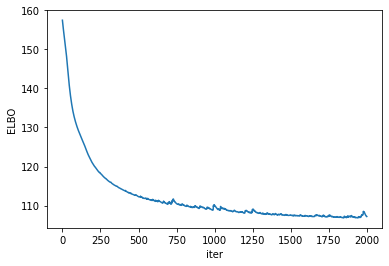

In [24]:
plt.plot(loss_list)
plt.xlabel("iter")
plt.ylabel("ELBO")

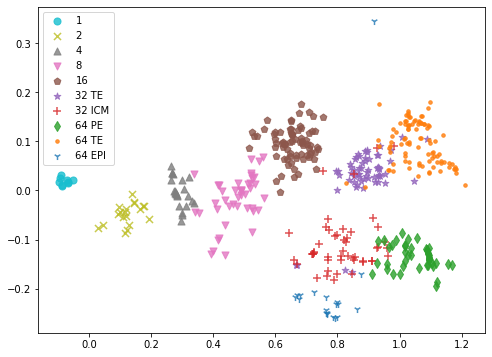

In [29]:
colors = plt.get_cmap("tab10").colors[::-1]
markers = ["o", "x", "^", "v", "p", "*", "+", "d", ".", "1"]

labels = df.index.unique()
X = model.X.cpu().detach().numpy()

plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    X_i = X[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], color=colors[i], marker=markers[i], alpha=0.8, s =50, label=label)
plt.legend()